In [1]:
import json

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from tqdm import tqdm
from rouge_score import rouge_scorer

# Load dataset

In [2]:
def load_dataset(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line: {line}")
                print(f"Error: {e}")
    return data

In [3]:
train_pth = 'data/train_data.jsonl'
val_pth = 'data/val_data.jsonl'
test_pth = 'data/test_data.jsonl'

train_data = load_dataset(train_pth)
val_data = load_dataset(val_pth)
test_data = load_dataset(test_pth)

In [4]:
def dataframe_from_dict(data: dict):
  texts = [datum['text'] for datum in data]
  summaries = [datum['summary'] for datum in data]
  return pd.DataFrame({
      'text': texts,
      'summary': summaries
  })

In [5]:
train_dataset = Dataset.from_pandas(dataframe_from_dict(train_data))
val_dataset = Dataset.from_pandas(dataframe_from_dict(val_data))
test_dataset = Dataset.from_pandas(dataframe_from_dict(test_data))

In [6]:
train_dataset_mock = Dataset.from_pandas(dataframe_from_dict([train_data[0]]))

In [7]:
print(train_dataset)

Dataset({
    features: ['text', 'summary'],
    num_rows: 43176
})


# Train a model

In [25]:
model_name = "ukr-models/uk-summarizer"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [11]:
max_input_length = 512  # Truncate long articles
max_target_length = 128  # Truncate summaries

In [12]:
def preprocess_function(examples):
    inputs = examples['text']
    targets = examples['summary']

    # Tokenize inputs (the main text)
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

    # Tokenize targets (the summary) directly using `text_target`
    labels = tokenizer(text_target=targets, max_length=max_target_length, truncation=True, padding="max_length")

    # Add labels to model inputs
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [20]:
tokenized_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/43176 [00:00<?, ? examples/s]

Map:   0%|          | 0/5390 [00:00<?, ? examples/s]

In [13]:
tokenized_dataset_mock = train_dataset_mock.map(preprocess_function, batched=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [14]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [28]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results_20epochs",          # Output directory
    eval_strategy="epoch",           # Evaluate after each epoch
    save_strategy="epoch",           # Save the model each epoch
    save_total_limit=3,              # Limit to 3 checkpoints
    learning_rate=5e-5,              # Optimizer learning rate
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    weight_decay=0.01,               # Weight decay
    num_train_epochs=20,             # Number of epochs
    predict_with_generate=True,      # Generate summaries for evaluation
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="rouge1",  # Use ROUGE1 for model selection
    greater_is_better=True,          # Higher metric values indicate better performance
    report_to='none',
    fp16=False,
    save_safetensors=False,
)

In [14]:
rouge_metric = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
from nltk.tokenize import sent_tokenize
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for pred, label in zip(decoded_preds, decoded_labels):
        score = rouge_metric.score(pred, label)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)
    # Average and convert scores to percentage
    result = {metric: round((sum(values) / len(values)) * 100, 4) for metric, values in scores.items()}
    
    return result

In [29]:
rouge_metric.score("Перемога Трампа на виборах - ганьба для Америки.",
                   "Виграш Трампа на виборах у США - ганьба для країни.")

{'rouge1': Score(precision=0.5555555555555556, recall=0.7142857142857143, fmeasure=0.6250000000000001),
 'rouge2': Score(precision=0.375, recall=0.5, fmeasure=0.42857142857142855),
 'rougeL': Score(precision=0.5555555555555556, recall=0.7142857142857143, fmeasure=0.6250000000000001)}

In [30]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_val_dataset, # Validation dataset
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Pass metric computation function
)

/tmp/ipykernel_103998/1063105983.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [18]:
tokenized_dataset_mock = tokenized_dataset_mock.remove_columns(
    train_dataset_mock.column_names
)

In [19]:
# mock training
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,No log,3.111057,3.448300,0.000000,3.448300
2,No log,2.920943,6.896600,0.000000,3.448300
3,No log,2.747787,6.896600,0.000000,3.448300
4,No log,2.593189,6.896600,0.000000,3.448300
5,No log,2.458333,6.896600,0.000000,3.448300
6,No log,2.338976,6.896600,0.000000,6.896600
7,No log,2.229158,6.896600,0.000000,6.896600
8,No log,2.130953,6.896600,0.000000,6.896600
9,No log,2.040100,6.896600,0.000000,6.896600
10,No log,1.954070,6.896600,0.000000,6.896600


/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to con

TrainOutput(global_step=100, training_loss=0.8417868041992187, metrics={'train_runtime': 718.4332, 'train_samples_per_second': 0.139, 'train_steps_per_second': 0.139, 'total_flos': 67973677056000.0, 'train_loss': 0.8417868041992187, 'epoch': 100.0})

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,0.758700,0.628624,18.757700,7.762900,17.072300
2,0.736000,0.624891,18.743900,7.740900,17.043600
3,0.703500,0.623446,18.509400,7.650500,16.820300
4,0.705600,0.623345,18.708300,7.692300,17.027800
5,0.682300,0.624075,18.786100,7.877800,17.128900
6,0.660800,0.625896,18.674200,7.861900,17.039000
7,0.638000,0.625888,18.894500,7.846000,17.198000
8,0.638600,0.627413,18.900600,7.973900,17.269600
9,0.620600,0.630151,19.020500,7.995100,17.385400
10,0.612800,0.632058,18.913700,7.861200,17.276400


/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/code/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to con

TrainOutput(global_step=107940, training_loss=0.6315837829714244, metrics={'train_runtime': 38867.3235, 'train_samples_per_second': 22.217, 'train_steps_per_second': 2.777, 'total_flos': 5.869662961139712e+17, 'train_loss': 0.6315837829714244, 'epoch': 20.0})

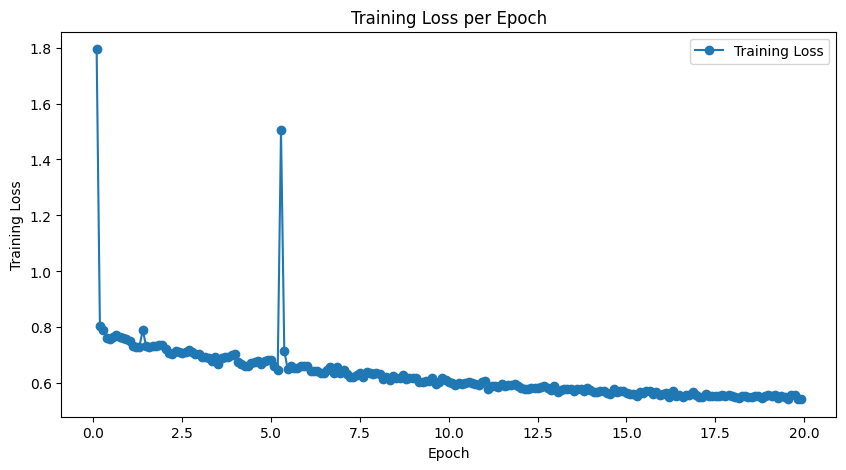

In [32]:
history_df = pd.DataFrame(trainer.state.log_history)

# Extract relevant metrics
train_loss = history_df[history_df['loss'].notna()][['epoch', 'loss']]
val_rouge1 = history_df[history_df['eval_rouge1'].notna()][['epoch', 'eval_rouge1']]
val_rouge2 = history_df[history_df['eval_rouge2'].notna()][['epoch', 'eval_rouge2']]
val_rougeL = history_df[history_df['eval_rougeL'].notna()][['epoch', 'eval_rougeL']]

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss['epoch'], train_loss['loss'], label="Training Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

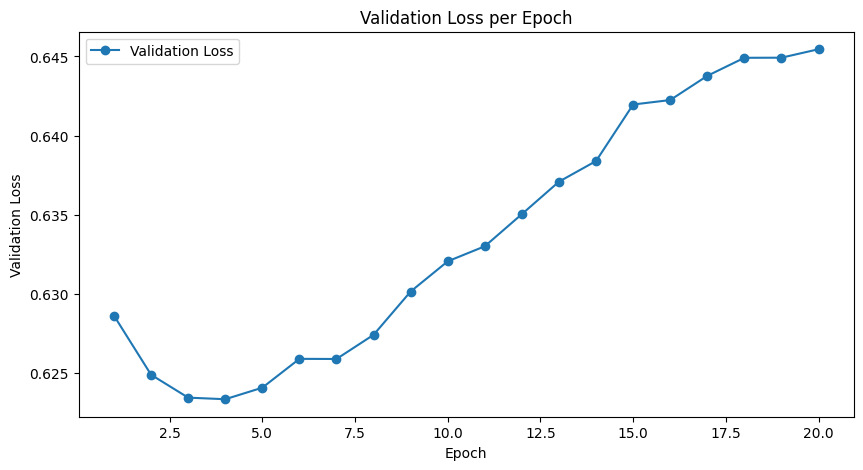

In [33]:
val_loss = history_df[history_df['eval_loss'].notna()][['epoch', 'eval_loss']]

# Plot Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(val_loss['epoch'], val_loss['eval_loss'], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.show()

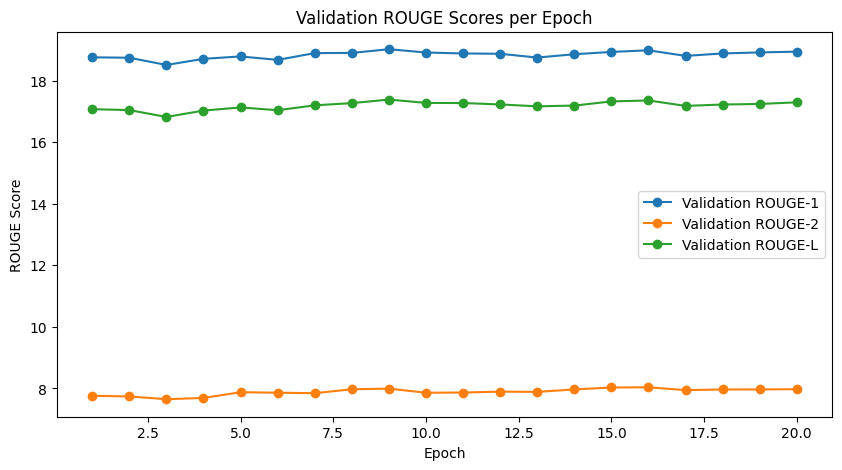

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(val_rouge1['epoch'], val_rouge1['eval_rouge1'], label="Validation ROUGE-1", marker='o')
plt.plot(val_rouge2['epoch'], val_rouge2['eval_rouge2'], label="Validation ROUGE-2", marker='o')
plt.plot(val_rougeL['epoch'], val_rougeL['eval_rougeL'], label="Validation ROUGE-L", marker='o')
plt.xlabel("Epoch")
plt.ylabel("ROUGE Score")
plt.title("Validation ROUGE Scores per Epoch")
plt.legend()
plt.show()

In [35]:
history_df.to_csv("/code/results_20epochs/training_history.csv", index=False)

In [8]:
model_dir = "./results_20epochs/checkpoint-107940"
model_loaded = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
tokenizer_from_loaded = AutoTokenizer.from_pretrained(model_dir, use_fast=False)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
def generate_summary(model, tokenizer, text, max_length=70, num_beams=5):
    """
    Generates a summary for the given text using a fine-tuned mT5 model.

    Args:
    text (str): The input text to summarize.
    max_length (int): Maximum length of the generated summary. Default is 70.
    num_beams (int): Number of beams for beam search. Higher values give better summaries but are slower. Default is 5.

    Returns:
    str: The generated summary text.
    """
    # Check the device of the model and move inputs to the same device
    device = model.device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1500).to(device)

    # Generate the summary
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True
    )

    # Decode the generated tokens to get the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [35]:
generate_summary(model_loaded, tokenizer_from_loaded, test_dataset[25]['text'])

'Турецькі військові літаки і вертольоти задіяні у бойових діях на півночі країни, повідомив міністр оборони країни Ільхам Їлдирим.'

In [36]:
test_dataset[25]['text']

'За даними агенцій, турецькі винищувачі уже здійнялися в повітря. При цьому не уточнюється, скільки саме літаків і вертольотів контролюють заколотники і де саме їх задіяно. Однак, Їлдирим поточнив, що авіація заколотників досі активна і продовжує наносити удари з повітря. Раніше повідомлялося, що підконтрольні заколотникам військові вертольоти беруть участь у обстрілах урядових будівель. Телеканал NTV стверджував, що один із гелікоптерів поцілив винищувач F-16. Підтверджень цієї інформації з інших джерел не надходило. Озброєний заколот почався у Туреччині ввечері 15 липня. Група військових заявила, що бере керування країною у свої руки - щоби забезпечити виконання конституційних прав громадян. Після цього вони оголосили в країні комендантську годину. Влада Туреччини висловила упевненість у тому, що заколотники не матимуть успіху. Президент країни Реджеп Таїп Ердоган закликав своїх прибічників виходити на вулиці. За кілька годин турецькі ЗМІ повідомили, що більшість організаторів заколо

In [21]:
generate_summary(model, tokenizer, train_dataset_mock[0]['text']),\
train_dataset_mock[0]['summary']

('У багатьох європейських містах є стіни, на яких художники зображають свій погляд на сучасну реальність. Але сучасна версія стінопису зародилася в Сполучених Штатах та на Заході.',
 'Вже кілька років на київських багатоповерхівках з\'являються сюжети з неприборканої уяви майстрів графіті з усього світу. Лише цього серпня принаймні на три прикрашені живописом стіни в столиці стало більше: "Просте щастя" - обличчя усміхненого чорношкірого хлопченяти, меморіальний портрет виконавця Linkin Park Честера Беннінгтона і філософська фреска "Розум, тіло і душа".')

In [12]:
def evaluate_dataset(
    dataset, model, tokenizer, max_length=70, num_beams=5, batch_size=8
):
    # Initialize variables
    results = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}
    sample_scores = []  # To store individual sample scores
    num_examples = 0
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    device = model.device

    # Process dataset in batches
    for i in tqdm(range(0, len(dataset), batch_size)):
        # Select batch
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        texts = batch["text"]  # Columnar access for "text"
        summaries = batch["summary"]  # Columnar access for "summary"

        # Tokenize inputs
        inputs = tokenizer(
            texts, return_tensors="pt", truncation=True, padding=True, max_length=512
        ).to(device)

        # Generate predictions
        with torch.no_grad():
            summary_ids = model.generate(
                inputs["input_ids"],
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True,
            )

        # Tokenize references (summaries)
        labels = tokenizer(
            text_target=summaries,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        ).to(device)

        # Decode predictions and references
        decoded_preds = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels["input_ids"], skip_special_tokens=True)

        # Compute ROUGE scores for each sample in the batch
        for text, pred, label, summary in zip(texts, decoded_preds, decoded_labels, summaries):
            rouge_scores = scorer.score(pred, label)
            sample_score = {
                "text": text,
                "reference_summary": summary,
                "generated_summary": pred,
                "rouge1": rouge_scores['rouge1'].fmeasure,
                "rouge2": rouge_scores['rouge2'].fmeasure,
                "rougeL": rouge_scores['rougeL'].fmeasure,
            }
            sample_scores.append(sample_score)

            # Accumulate scores for averaging
            results['rouge1'] += rouge_scores['rouge1'].fmeasure
            results['rouge2'] += rouge_scores['rouge2'].fmeasure
            results['rougeL'] += rouge_scores['rougeL'].fmeasure

        num_examples += len(batch)

    # Average the results
    averaged_results = {metric: round((score / num_examples) * 100, 4) for metric, score in results.items()}

    # Convert sample scores to a DataFrame for easy analysis
    sample_scores_df = pd.DataFrame(sample_scores)
    return averaged_results, sample_scores_df


In [13]:
tokenizer = tokenizer_from_loaded
val_scores, val_scores_df = evaluate_dataset(val_dataset, model_loaded.cuda(), tokenizer_from_loaded, batch_size=2)

100%|█████████████████████████████████████████████████████████████████| 2695/2695 [40:07<00:00,  1.12it/s]


In [14]:
val_scores

{'rouge1': 24.752, 'rouge2': 10.7771, 'rougeL': 21.5121}

In [16]:
tokenizer = tokenizer_from_loaded
test_scores, test_scores_df = evaluate_dataset(test_dataset, model_loaded.cuda(), tokenizer_from_loaded, batch_size=2)

100%|█████████████████████████████████████████████████████████████████| 2697/2697 [40:29<00:00,  1.11it/s]


In [17]:
test_scores

{'rouge1': 24.2658, 'rouge2': 10.3223, 'rougeL': 21.0881}

In [15]:
val_scores_df.to_csv("/code/val_scores_df.csv")

In [18]:
val_scores_df["rouge"] = val_scores_df["rouge1"] + val_scores_df["rouge2"] + val_scores_df["rougeL"]

In [21]:
test_dataset.select([4])["text"]

['Чи збереже Україна контроль над майном Нафтогазу після його реструктуризації? Знайдіть відмінності Поки що проект закону, розробником якого є депутат від НУНС Юрій Кармазін, передбачає, що національна акціонерна компанія "Нафтогаз" та її підрозділи можуть реструктуруватися, але всі вони, а також компанії, що виникнуть після цієї реструктуризації, не можуть бути приватизовані, їх основні фонди чи акції бути продані або передані в концесію чи лізинг. Також передбачається, що проти НАК "Нафтогаз" чи її дочірніх компаній не може бути порушена справа про банкрутство. Все це відрізняє ухвалений у першому читанні законопроект від попереднього, запропонованого урядом, який, зокрема, передбачав, що право реформувати та реструктурувати "Нафтогаз" отримає уряд. Опозиція вбачала у цьому перший крок до підготовки передачі контролю над українською газотранспортною системою Росії, і блокувала парламентську трибуну щоразу, коли депутати починали розгляд цього законопроекту. Уряд твердив, що єдиною м

In [29]:
val_scores_df = val_scores_df.sort_values(by="rouge", ascending=True)

for i, row in enumerate(val_scores_df.itertuples()):
    if i == 5:
        break
    print(f"#{i + 1}")
    summary = row.reference_summary
    text = val_dataset.select([row.Index])["text"][0]
    prediction = row.generated_summary

    print(f"\ttext: {text}")
    print(f"\treference summary: {row.reference_summary}")
    print(f"\tgenerated summary: {row.generated_summary}")

#1
	text: Такий висновок зробили після того, як група експертів провела розслідування випадків незрозумілих легеневих хвороб у США, які могли бути пов'язані з використанням електронних сигарет. Центр з контролю та профілактики захворювань США (CDC) заявив, що у 22 штатах зафіксували 193 потенційні випадки. За словами експертів, у багатьох випадках причина хвороб — вживання через вейпінг ТГК — головного психоактивного компонента канабісу. Випадки зафіксували протягом двох місяців між 28 червня та 20 серпня. Людину, яка загинула, "госпіталізували з незрозумілою хворобою після вейпінгу, або використання електронних сигарет", - сказала доктор Дженніфер Лейден, головний лікар та епідеміолог штату Іллінойс. Директор Центру з контролю та профілактики захворювань Роберт Редфілд заявив: "Нам сумно дізнатися про першу смерть, пов'язану із розвитком важкої хвороби легенів у тих, хто використовує електронні сигарети або пристрої для вейпінгу". Він додав: "Ця трагічна смерть в Іллінойсі підкреслює 

In [30]:
val_scores_df = val_scores_df.sort_values(by="rouge", ascending=False)

for i, row in enumerate(val_scores_df.itertuples()):
    if i == 5:
        break
    print(f"#{i + 1}")
    summary = row.reference_summary
    text = val_dataset.select([row.Index])["text"][0]
    prediction = row.generated_summary

    print(f"\ttext: {text}")
    print(f"\treference summary: {row.reference_summary}")
    print(f"\tgenerated summary: {row.generated_summary}")

#1
	text: Видавництво "Видавництво Старого Лева" презентує книгу Ірини Савки "Осиний мед дикий": Ці короткі, майже скупі оповіді, в яких клекочуть стефаниківські пристрасті та гаряча українська історія разом із сьогоденням, ніби водномить зійшли із гір високого людського духу і підлої ницості, непоказної щирості і лютої неправди. У цих образних та мінімалістських історіях сконденсовано цілі саги українського життя. Анотація надана видавництвом. Книга "Осиний мед дикий" потрапила до "довгого списку" премії Книга року ВВС-2013. Усього до нього увійшли 20 книжок. Премія Книга року ВВС-2013 проходить у співпраці з Культурною програмою Європейського Банку Реконструкції та Розвитку (ЄБРР).
	reference summary: Книжкова премія ВВС Україна Книга року ВВС-2013 представляє кожну з книжок "довгого списку" (претендентів на звання Книги року).
	generated summary: Книжкова премія ВВС Україна Книга року ВВС-2013 представляє кожну з книжок "довгого списку" (претендентів на звання Книги року).
#2
	text: